## 任务描述

赛题来自数愿组织的病理切片AI识别挑战赛初赛赛题（www.datadreams.org/race-race-3.html）。 官方描述如下：


### 赛题设置：

大赛选取胃癌病理切片图像为比赛数据，参赛团队运用人工智能的技术，开发算法模型，即通过胃癌病理切片数据，检测判断病理切片图像有无癌症。大赛通过探索胃癌病理切片智能诊断的优秀算法，提升胃癌检测的效率，协助医生诊疗。参赛者可下载数据，在本地调试算法，提交结果由机器自动评测成绩，并定时公布排行榜。

### 数据描述：
初赛选取胃癌病理切片，为常规HE染色，放大倍数20×，图片大小为2048×2048像素，比赛数据为整体切片的部分区域，tiff 格式。比赛不允许使用外部数据。 初赛选取100个病人案例（部分为癌症、部分为非癌症），共计1000张病理切片图片，训练集数量700张，测试集数量300张。

### 数据标注：
病理专家将数据标记（双盲评估+验证）为有无癌症，并用线条画出肿瘤区域轮廓。

原始数据以及标注数据内容如下：

原始数据|标注数据
---|---
![](./FCN/example_image.png)|![](./FCN/example_label.png)


## 总体思路

由于需要实现像素级别的图像分割，所以我们考虑使用全卷积神经网络(FCN)，用这种架构：

![](./vgg16_based_FCN.png)

来自 [PCA-aided Fully Convolutional Networks for Semantic Segmentation of Multi-channel fMRI]

在这种架构基础之上，我们有以下想法：

- 图形分辨率很高，我们可以考虑将一张图片拆分为多张小图片，进行模型训练。
- 由于只有700张图片，并且是 RGB 图片，根据我们在第八章猫狗大战中的经验，以及最后提到的皮肤癌判断项目的分析架构，这里考虑引入迁移学习。
- 样本数量有限，可能会有过拟合现象发生。考虑在反卷积层中，引入 l2 正则化。
- 样本数量有限，考虑进行数据增强。

对于第一点，其实我们的训练图像已经是经过切割之后的图片了——病理切片的图片大小通常是上万个像素点x上万个像素点的分辨率，这里已经是切割成 2048x2048 的小图片了。这里测试中，发现直接将 2048x2048 的输入图片转换成 256x256分辨率后训练，单张 GPU 占用 10G 显存的情况下，训练模型通常需要接近两小时的时间。因此这里我就不继续将图片拆成小图片了，直接将输入图片分辨率转换成 256x256，降低分辨率直接训练。读者如果在云服务器租用显存更高、显卡更多的机器，可以考虑将图片进行二次裁剪，剪成更多的图片，而不是简单的减小分辨率，进而用更高的分辨率训练模型。


对于第二点，我们可以直接将 vgg16 模型中，imageNet 的训练结果运用在这里，在此基础上，进一步的添加反卷积层。

对于第三点，引入正则化的话，同我们第一章逻辑斯蒂回归类似，在引入 l2 正则化时，需要注意在损失函数处，将模型的权重加进去。

对于第四点，由于病理切片不涉及拍摄的角度问题，可以引入旋转以及小范围的缩放。但由于癌症区域在颜色、形态、细小颗粒等特征会和正常区域有所区别，因此数据增强的过程中，不引入噪点，不改变颜色。


## 构造模型

由于这部分内容需要实现的功能比较复杂，不再是像之前一样的顺序执行(Sequencial)的架构，这里没有继续使用 `keras` 框架。但实际上，我们也没有必要直接用更底层的 `tf.nn` 模块，现有版本 tensorflow (v1.1.0) 的`tf.layers` 模块使用起来也很方便。

模型编写，仍然遵循三段论——准备数据，构建模型以及模型优化。

### 准备数据

准备数据中，我们遇到的第一个问题，就是如何处理 svg 格式的标注数据。首先，svg 的标注，看起来是一个空心的区域，实际模型训练过程中，需要将其转换成实心区域。其次，svg 是一种矢量图，并不是以矩阵的形式存储的，需要将其转换为矩阵。

对于第一点，我们打开svg文件，发现这里标注区域使用了诸如 `<polygon fill="none" points="537,742 ... 537,742" stroke="#f8691c" stroke-width="5" />` 这样的形式，我们意识到，图像是空心的原因，是因为 fill 里面写的内容是 none，可以给改成黑色，换成 `fill="#FFFFFF`。但我们同时注意到标注区域有橘黄色的边，填充色换成黑色的同时，也需要将多边形区域边的颜色设置为黑色。于是这里可以考虑使用正则表达式直接替换：

```python
svg_code = re.sub(r'''fill="(\w+|None)"''', '''fill="#FFFFFF"''', svg_code)
svg_code = re.sub(r'''stroke="(\w+|None)"''', '''stroke="#FFFFFF"''', svg_code)
```

然后对第二点，将修改后svg结果，以 png 的格式保存下来：

```python
svg2png(bytestring=svg_code, write_to="out.png")
```

完整函数：

```python
def get_image(path, shape):
    """
    使用 opencv 读取图像
    :param  path  输入图像路径
    :param  shape 输出图像大小
    :return image 以[H,W,C]的RGB矩阵形式，输出图像
    """
    image = cv2.imread(path)
    image = image[:,:,::-1]
    if shape != None:
        image = cv2.resize(image, shape)
    return image
 
def svg_process(svg_file, shape):
    """
    将癌细胞区域标注的矢量图 svg 格式的文件标注，转换成矩阵，并读入
    :param  svg_file  输入矢量图图像路径
    :param  shape     输出图像大小
    :return x         以灰度矩阵形式，输出癌细胞区域标注的结果
    """
    image_dir    = os.path.dirname(svg_file)
    image_prefix = os.path.basename(svg_file).split(".svg")[0]
    if not os.path.isfile("%s/%s.png" % (image_dir, image_prefix)):
        with open(svg_file, "r") as f_in:
            svg_code = f_in.readlines()
            svg_code = "".join(svg_code[1:])
            svg_code = re.sub(r'''fill="(\w+|None)"''', '''fill="#FFFFFF"''', svg_code)
            svg_code = re.sub(r'''stroke="(\w+|None)"''', '''stroke="#FFFFFF"''', svg_code)
            svg2png(bytestring=svg_code, write_to="%s/%s.png" % (image_dir, image_prefix))
 
    img = get_image("%s/%s.png" % (image_dir, image_prefix), shape)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
```

这部分遇到的第二个问题，是数据增强。我们首先考虑能否直接使用 `Keras` 的现成函数，如同我们第七章 CIFAR10 以及第八章猫狗大战中的代码一样。

但是，麻烦事来了，我们查阅 Keras API 后，发现 `keras.preprocessing.image` 的这个模块中，之前使用的`ImageDataGenerator`这个函数，输出的是一个图像矩阵，外加一个分类种类的标签。而我们需要的，是一个图像矩阵，以及一个经过同样旋转、缩放变换的标注矩阵。这个功能 `keras` 里，目前(v2.0.4)并没能够直接实现。于是我们需要写一个可以同时旋转病理图像以及标注图像的函数。

>注：比较打脸的是，Keras API 虽然没有直接实现这个功能，但是官方文档中有提供如何使用 `ImageDataGenerator` 同时变换图像和标注区域的案例。具体而言就是用两个参数相同的生成器，使用同一套随机种子，对不同文件夹的输入执行两次即可。笔者写完下面的代码之后，考虑能否给 Keras 项目“贡献自己一份力量”时，发现了这一点：

```python
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(images, augment=True, seed=seed)
mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    'data/images',
    class_mode=None,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    'data/masks',
    class_mode=None,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

model.fit_generator(
    train_generator,
    steps_per_epoch=2000,
    epochs=50)
```

>所以接下来的内容，大家可以当成学习材料，实际运用中，可以考虑使用更简单的 Keras 官方案例。

实现这个功能的方法有很多，这里我用的方法是，改造 keras 功能接近的函数。`keras.preprocessing.image` 这个模块位于 https://github.com/fchollet/keras/blob/2.0.4/keras/preprocessing/image.py, 看起来相对独立，没有复杂的引用关系，因此我们可以简单的阅读下 keras 如何在一张图片中实现图像反转、缩放，进而通过简单的改造，实现在另一张图片中，执行同样操作。

首先回忆第七章，我们是如何对 CIFAR-10 数据使用生成器的：

```python
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(...)
datagen.fit(X_train)
```

于是我们在 `ImageDataGenerator` 类中的 `fit` 方法，进一步定位到 `augment`，以及 `random_transform` 方法所在的位置：

```python
# 649-654, fit
if augment:
    ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
    for r in range(rounds):
        for i in range(x.shape[0]):
            ax[i + r * x.shape[0]] = self.random_transform(x[i])
    
    x = ax

theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)

# 566-570 random_transform
if theta != 0:
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    transform_matrix = rotation_matrix

# 584-588 random_transform
if zx != 1 or zy != 1:
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])
    transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)
            
            
# 593-594 random_transform
x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)
```

我们发现，keras 这部分代码的逻辑是，首先从定义的范围以内，根据均匀分布（uniform），随机生成一个旋转角、缩放比，进而通过一个大小为 3x3 的转换矩阵（transform_matrix）来表示旋转、缩放。最终通过 `apply_transform` 函数实现图像的旋转、缩放。

那么我们的改造思路，就是根据我们定义的旋转、缩放范围，随机生成旋转角、缩放比之后，进而生成转换矩阵，再分别将这个转换矩阵应用在输入病理图片以及癌症区域标注图片上。代码如下：

```python
def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='constant',
                    cval=0.):
    """
    进行图像旋转。简化改写了：
        https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py
    
    :param  x                输入需要旋转的图像向量
    :param  transform_matrix 图像旋转矩阵参数
    :param  channel_axis     哪一个维度代表图像的编号。对 [N,H,W,C]，N是图像编号，所以是0
    :param  fill_mode        填充由于旋转造成的边缘空白的方式。
                             可选 {'constant', 'nearest', 'reflect', 'wrap'}
    :param  cval             如果是'constant'填充，则在空白处填写什么内容
    
    :return x                旋转后的图像
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    
    # 对癌症样本，同时有病理切片以及癌症区域标注图片
    if cval is False:
        cha_img1 = scipy.ndimage.interpolation.affine_transform(
            x[0], final_affine_matrix, final_offset, order=0, mode=fill_mode, cval=False)
        cha_img2 = scipy.ndimage.interpolation.affine_transform(
            x[1], final_affine_matrix, final_offset, order=0, mode=fill_mode, cval=True)
        channel_images = [cha_img1, cha_img2]
    
    # 对非癌症样本，不存在癌症区域标注图片
    else:
        channel_images = [scipy.ndimage.interpolation.affine_transform(
            x_channel,
            final_affine_matrix,
            final_offset,
            order=0,
            mode=fill_mode,
            cval=cval) for x_channel in x]

    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def picture_argument(image_input, image_gt, rotate, zoom):
    """
    对输入的病理切片，进行旋转、缩放操作的图像增强，并生成经过同样旋转、缩放操作的标注区域
    
    :param  image_input           输入的病理切片图像
    :param  image_gt              输入的病例切片癌症标注区域图像
    :param  rotate                对图像进行旋转的正负角度范围
    :param  zoom                  对图像进行缩放操作的放大缩小百分比
    :return image_input，image_gt 旋转、缩放后的病理切片图像，以及对应的癌症区域标注
    """
    theta = np.pi / 180 * np.random.uniform(-rotate, rotate)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    transform_matrix = rotation_matrix
    zx, zy = np.random.uniform(1-zoom, 1+zoom, 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])
    transform_matrix = np.dot(transform_matrix, zoom_matrix)

    h, w = image_input.shape[0], image_input.shape[1]
    transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
    image_input = apply_transform(image_input, transform_matrix, 2,
                                fill_mode="constant", cval=255)

    image_gt = apply_transform(image_gt, transform_matrix, 2,
                                fill_mode="constant", cval=False)
    return image_input, image_gt

```

大功告成。接下来将这些函数包装进生成器。由于训练样本、验证样本需要有各自的生成器，因此这里在生成器函数 `batch_gen`外面加一层，这样就可以给两组样本每组分配一个生成器。

```python
def gen_batch_func(l_sample, image_shape):
    """
    生成器函数，输入样本名称，每调用一次生成器，输出若干张病例切片图片以及对应的癌症区域标注图片
    
    :param  l_sample      输入的病理切片图像样本名称，
                          对应的病理切片图像放在 ./FCN/image/merge 目录下
                          对应的病理切片癌症区域标注放在 ./FCN/labels 目录下
    :param  image_shape   输出图片的大小
    :return batch_gen     输出生成器，每调用一次生成器，输出若干张病例切片图片以及对应的癌症区域标注图片
    """
    def batch_gen(batch_size, augmentation=True):
        random.shuffle(l_sample)
        for batch_i in range(0, len(l_sample), batch_size):
            l_images = []
            l_gt_images = []
            for sample in l_sample[batch_i:batch_i+batch_size]:
                gt_image_file = "./FCN/labels/%s.svg" % (sample)
                image_file = "./FCN/image/merge/%s.tiff" % (sample)
                if os.path.isfile(gt_image_file):
                    gt_image_raw = svg_process(gt_image_file, shape=image_shape)

                else:
                    gt_image_raw = np.zeros([image_shape[0], image_shape[1]])

                image = get_image(image_file, shape=image_shape)
                gt_image = gt_image_raw>100
                gt_image = gt_image.reshape(*gt_image.shape, 1)
                gt_image2 = np.bitwise_not(gt_image)
                gt_out = np.concatenate((gt_image, gt_image2), axis=2)

                if augmentation:
                    rotation = 180
                    zoom = 0.2
                    image,gt_out = picture_argument(image, gt_out, rotation, zoom)

                l_images.append(image)
                l_gt_images.append(gt_out)

            yield np.array(l_images), np.array(l_gt_images)

    return batch_gen
```


### 构建模型

模型的构建阶段，主要分为两个部分。一是首先导入用 ImageNet 预训练的 vgg16 模型。这里如果直接使用官方地址的`ckpt`格式的模型的话，需要首先将其转换成 `.pb` 格式的模型，并将 `ckpt` 中的参数值写入 `.pb` 文件。

这样做是因为直接加载`.pb` 格式的模型加载起来相对容易，`ckpt`格式只有参数，没有图的定义，需要在代码中定义模型结构，或者导入其他 `.pb` 文件。而 `.pb` 格式可以只存储图的模型，也可以进一步通过 `tensorflow`的 `freeze_graph` 功能，将参数写入 `.pb` 文件。我们这里为了省事，直接下载转换完成后的 vgg16 `.pb` 文件。

```python
def load_vgg(sess, vgg_path):
    """
    载入 VGG16 预训练模型，返回我们基于 VGG16 训练全卷积神经网络(FCN)所必须的中间变量。
    :param  sess:     TensorFlow Session
    :param  vgg_path: vgg16 模型文件的下载路径。模型使用pb格式存储，
                     下载地址：https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip
    
    :return image_input, keep_prob, layer3_out, layer4_out, layer7_out
                     返回我们基于 VGG16 训练 全卷积神经网络(FCN) 所必须的中间变量
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    input_image = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    vgg_layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    vgg_layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    return input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out
```

第二部分是在 vgg16 模型的基础上，构建全卷积神经网络。这里我们根据 [fully convolutional networks for semantic segmentation]这篇文章给定的网络结构，直接构建模型。这里面需要注意的是，首先参数需要合理的初始化，我们在第四章内容介绍卷积层时，提到卷积层的初始化过程中，要注意随着层数的增多，随机初始化引入的方差，会随着连续的乘法运算，累计增加或者减少，进而影响整个梯度的计算。因此我们这里同样需要注意参数的合理初始化，这里引入了 `xavier_initializer()`。其次我们可以将卷积核通过`tf.slice` 抽出来作为灰度图像，通过 `tf.summary.image()` 留下记录，这样我们就可以在 tensorboard 中看见卷积核的结果。深度学习虽然由于不容易解释，被人当作“玄学”，但实际上并非无法解释，通过对卷积核进行可视化分析，会给我们提供很多有用信息。

![](./tensorboard_kernel.png)

```python
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    基于 load_vgg 返回的VGG16模型中间结果，设计全卷积神经网络(FCN)模型
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: 需要分类的种类数目。这里是肿瘤区域/非肿瘤区域的二分类
    :return: 全卷积神经网络模型（FCN）的输出结果
    """
    with tf.name_scope("32xUpsampled") as scope:
        conv7_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1,
                                        padding='same', name="32x_1x1_conv",
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(g_l2),
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv7_2x  = tf.layers.conv2d_transpose(conv7_1x1, num_classes, 4,
                                        strides=2, padding='same', name="32x_conv_trans_upsample",
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(g_l2),
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())

    with tf.name_scope("16xUpsampled") as scope:
        conv4_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1,
                                        padding='same', name="16x_1x1_conv",
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(g_l2),
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv_merge1 = tf.add(conv4_1x1, conv7_2x, name="16x_combined_with_skip")
        conv4_2x  = tf.layers.conv2d_transpose(conv_merge1, num_classes, 4,
                                        strides=2, padding='same', name="16x_conv_trans_upsample",
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(g_l2),
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())

    with tf.name_scope("8xUpsampled") as scope:
        conv3_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1,
                                        padding='same', name="8x_1x1_conv",
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(g_l2),
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv_merge2 = tf.add(conv3_1x1, conv4_2x, name="8x_combined_with_skip")
        conv3_8x  = tf.layers.conv2d_transpose(conv_merge2, num_classes, 16,
                                        strides=8, padding='same', name="8x_conv_trans_upsample",
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(g_l2),
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())

    conv_image_0 = tf.slice(conv3_8x, [0,0,0,0], [-1,-1,-1,1])
    tf.summary.image("conv3_8x_results_0", conv_image_0)
    return conv3_8x

```

### 模型优化

有目标，才有优化。之前我们做图像分类，目标就是尽可能的多将图片的种类分对。而现在我们做单个像素的图像分割，目标就是**尽可能多的将图片中每一个像素的内容都分对**。这个目标我们可以用交叉熵来代表，写成程序就是：

```python
entropy_val = tf.nn.softmax_cross_entropy_with_logits(labels=true_label, logits=pred_label)
cross_entropy_loss = tf.reduce_sum(entropy_val)
```

不过我们在最开始的总体思路中，强调了这里由于样本少，需要引入正则化防止过拟合。所以我们的目标要再加一条，就是**在尽可能多的将图片中每一个像素的内容都分对的基础上，尽可能使用更少、更小的参数，防止参数过多造成对数据的过度迎合**。这个升级版的目标，写成程序就是：

```python
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) # 收集反卷积层用到的参数
loss = cross_entropy_loss +  sum(reg_losses) # 更新的目标函数，将所有参数的平方和纳入优化目标
```

除了我们自己定义的目标以外，我们也需要考虑这项比赛的指标—— F1 值。比赛官网定义如下：

```
Evaluation of Cancerous Region Segmentation:

Precision=(|TP|)/(|TP|+|FP|)
Recall=(|TP|)/(|TP|+|FN|)
F1 Score=(2∙Precision∙Recall)/(Precision+Reall)

●    TP：True Positive，被分类为属于癌变区域，但分类正确；
●    FP：False Positive，被分类为属于癌变区域，但分类错误；
●    FN：False Negative，被分类为属于非癌变区域，但分类错误。
```

于是根据他的定义，我们写一个 F1 值的算式，作为一个独立于我们优化指标的另一项评价指标：

```python
argmax_p = tf.argmax(pred_label, 1)
argmax_y = tf.argmax(true_label, 1)
TP = tf.count_nonzero( argmax_p   * argmax_y,    dtype=tf.float32)
TN = tf.count_nonzero((argmax_p-1)*(argmax_y-1), dtype=tf.float32)
FP = tf.count_nonzero( argmax_p   *(argmax_y-1), dtype=tf.float32)
FN = tf.count_nonzero((argmax_p-1)* argmax_y,    dtype=tf.float32)
precision = TP / (TP+FP)        
recall    = TP / (TP+FN)        
f1 = 2 * precision * recall / (precision + recall)
```

完整代码如下：

```python
def optimize(nn_last_layer, correct_label, learning_rate, num_classes, batch_size, split_idx):
    """                                 
    定义模型的优化目标（损失函数），设置优化器
    :param  nn_last_layer:     全卷积神经网络模型（FCN）的输出结果
    :param  correct_label:     病理切片对应的、准确的癌症区域标注
    :param  learning_rate:     初始学习率大小
    :param  num_classes:       需要分类的种类数目。这里是癌症区域/非癌症区域的二分类
    :return pred_label:        病理切片对应的、模型预测的癌症区域标注
    :return training_op:       优化器   
    :return cross_entropy_loss 交叉熵损失函数
    :return f1                 比赛规定的评价指标 f1 值
    :return learning_rate2     随训练次数逐步衰减后的学习率的大小
    """                                 
    pred_label = tf.reshape(nn_last_layer, [-1, num_classes], name="predicted_label")
    true_label = tf.reshape(correct_label, [-1, num_classes], name="true_label")
                                        
    with tf.name_scope("f1_score"):     
        argmax_p = tf.argmax(pred_label, 1)
        argmax_y = tf.argmax(true_label, 1)
        TP = tf.count_nonzero( argmax_p   * argmax_y,    dtype=tf.float32)
        TN = tf.count_nonzero((argmax_p-1)*(argmax_y-1), dtype=tf.float32)
        FP = tf.count_nonzero( argmax_p   *(argmax_y-1), dtype=tf.float32)
        FN = tf.count_nonzero((argmax_p-1)* argmax_y,    dtype=tf.float32)
        precision = TP / (TP+FP)        
        recall    = TP / (TP+FN)        
        f1 = 2 * precision * recall / (precision + recall)
                                        
    with tf.name_scope("cross_entropy_loss"):
        entropy_val = tf.nn.softmax_cross_entropy_with_logits(labels=true_label, logits=pred_label)
        cross_entropy_loss = tf.reduce_sum(entropy_val)
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = cross_entropy_loss +  sum(reg_losses)
                                        
    with tf.name_scope("train"):         
        batch = tf.Variable(0, tf.float32)
        learning_rate2 = tf.train.exponential_decay(
                      learning_rate,       # Base learning rate.
                      batch * batch_size,  # Current index into the dataset.
                      split_idx,           # Decay step.
                      0.95,                # Decay rate.
                      staircase=True)    
        
        # 不使用 learning_rate decay 策略的话，直接用 learning_rate
        #optimizer = tf.train.AdamOptimizer(learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate2)
        training_op = optimizer.minimize(loss, global_step=batch)
                                         
    return pred_label, training_op, cross_entropy_loss, f1, learning_rate2

```

`optimizer` 函数作用于训练集，该函数输入了现有模型预测的结果以及真实结果，返回了对训练集数据表现的评价（交叉熵以及f1值），最后提出对整个模型参数的优化。而对于验证集，我们同样可以得到现有模型对于验证集的预测结果以及验证集真实结果，但我们只需要对这个结果进行评价，不可以用验证集优化模型，因此对验证集的评价方法我们可以写成：

```python
def validation(nn_last_layer, correct_label, num_classes):
    """
    每当模型遍历所有训练样本（80%，560个）之后，对剩下20%的验证样本执行一次验证操作，检验模型在新样本上的表现
    :param  nn_last_layer:        全卷积神经网络模型（FCN）的输出结果
    :param  correct_label:        病理切片对应的、准确的癌症区域标注
    :param  num_classes:          需要分类的种类数目。这里是癌症区域/非癌症区域的二分类
    :return cross_entropy_loss_cv 交叉熵损失函数(验证样本)
    :return f1_cv                 比赛规定的评价指标 f1 值(验证样本)
    """
    pred_label = tf.reshape(nn_last_layer, [-1, num_classes], name="predicted_label_cv")
    true_label = tf.reshape(correct_label, [-1, num_classes], name="true_label_cv")
 
 
    with tf.name_scope("f1_score_cv"):
        argmax_p = tf.argmax(pred_label, 1)
        argmax_y = tf.argmax(true_label, 1)
        TP = tf.count_nonzero( argmax_p   * argmax_y,    dtype=tf.float32)
        TN = tf.count_nonzero((argmax_p-1)*(argmax_y-1), dtype=tf.float32)
        FP = tf.count_nonzero( argmax_p   *(argmax_y-1), dtype=tf.float32)
        FN = tf.count_nonzero((argmax_p-1)* argmax_y,    dtype=tf.float32)
        precision = TP / (TP+FP)
        recall    = TP / (TP+FN)
        f1_cv = 2 * precision * recall / (precision + recall)
 
    with tf.name_scope("cross_entropy_loss_cv"):
        entropy_val = tf.nn.softmax_cross_entropy_with_logits(labels=true_label, logits=pred_label)
        cross_entropy_loss_cv = tf.reduce_sum(entropy_val)

    return cross_entropy_loss_cv, f1_cv
```

我们明确了优化目标之后，我们还需要做的一件事，就是身体力行的优化这个模型。这部分内容，在第七章 `Keras` 版本中，只用 `model.fit` 一行就完成了。但我们这里情况比较复杂，首先我们进来的数据并不是常见的分类数据，其次我们的优化目标考虑L2正则化之后也更加复杂。因此这里我们还是要多写几行，实现：

- 多个 `eproch`训练
- 每个 `eproch`中，每次喂给模型 `batch_size` 个数的样本，进行一次训练
- 将这次训练的交叉熵以及 F1 值，写入 tensorboard 日志文件
- 完成一个 eproch的训练后，用验证集检验训练模型的表现（交叉熵/F1值）

函数实现如下：

```python
def train_nn(sess, epochs, batch_size, get_batches_train, get_batches_cv, train_op, cross_entropy_loss,
             cross_entropy_loss_cv, f1, f1_cv,lr, input_image, correct_label, keep_prob, learning_rate):
    """
    汇总之前的结果，训练定义的全卷积神经网络
    :param sess:                   TF Session
    :param epochs:                 训练几轮数据
    :param batch_size:             批次大小
    :param get_batches_train:      获取训练数据的生成器，使用方法 gen_batch_func(batch_size)
    :param get_batches_cv:         获取验证数据的生成器，使用方法 gen_batch_func(batch_size)
    :param train_op:               训练模型的操作子，优化目标 cross_entropy_loss+l2_loss 最小化
    :param cross_entropy_loss:     交叉熵损失函数(训练样本)
    :param cross_entropy_loss_cv:  交叉熵损失函数(验证样本)
    :param f1:                     比赛规定的评价指标 f1 值(训练样本)
    :param f1_cv:                  比赛规定的评价指标 f1 值(验证样本)
    :param input_image:            模型输入图片大小
    :param correct_label:          病理切片对应的、准确的癌症区域标注
    :param keep_prob:              VGG 模型中间参数
    :param learning_rate:          初始化学习率大小
    
    """
    #save training results for every eproch
    saver = tf.train.Saver()
    model_dir = './usingNonAug_models_l2_norm_ExpDecay_lr_%1.2e_l2_%1.2e_e10_batch_%d' % (g_lr, g_l2, g_batch_size)
    log_dir   = "./usingNonAug_logs_l2_norm_ExpDecay_lr_%1.2e_l2_%1.2e_e10_batch_%d"  % (g_lr, g_l2, g_batch_size)
    cv_dir    = "./usingNonAug_cv_ExpDecay_lr_%1.2e_l2_%1.2e_e10_batch_%d.csv"  % (g_lr, g_l2, g_batch_size)
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)

    if not os.path.isdir(log_dir):
        os.mkdir(log_dir)

    f_out = open(cv_dir, "w")
    f_out.write("Eproch,cv_CrossEntropy_loss,cv_F1\n")

    summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

    sess.run(tf.global_variables_initializer())
    tf.summary.scalar("train_loss", cross_entropy_loss)
    tf.summary.scalar("train_f1", f1)
    merged_summary_op = tf.summary.merge_all()

    global_iteration_idx = 0
    for i in range(epochs):
        print("Epoch %d" % i)
        ii = 0
        for batch_image,batch_label in get_batches_train(batch_size, augmentation=True):
            ii += 1
            global_iteration_idx += 1
            train_op_,cross_entropy_loss_,summary_str,f1_,lr_ = sess.run(
                     [train_op, cross_entropy_loss, merged_summary_op, f1, lr],
                     feed_dict={
                        input_image: batch_image,
                        correct_label: batch_label,
                        learning_rate : g_lr,
                        keep_prob : 0.5
            })
            summary_writer.add_summary(summary_str, global_iteration_idx)
            print("Eproch %d, Iteration %d, loss = %1.5f, f1 = %1.5f, lr = %1.5f" % (i, ii, cross_entropy_loss_, f1_, lr_))

        # Save the model every eproch
        l_f1_cv = []
        l_loss_cv = []

        for batch_image,batch_label in get_batches_cv(batch_size, augmentation=False):
            cross_entropy_loss_, f1_ = sess.run(
                     [cross_entropy_loss_cv, f1_cv],
                     feed_dict={
                        input_image: batch_image,
                        correct_label: batch_label,
                        keep_prob : 0.5
            })
            l_loss_cv.append(cross_entropy_loss_)
            l_f1_cv.append(f1_)

        np_loss_cv = np.array(l_loss_cv)
        np_f1_cv   = np.array(l_f1_cv)
        f_out.write("%d,%1.5f,%1.5f\n" % (i, np.nanmean(np_loss_cv), np.nanmean(np_f1_cv)))
        print("Validation, Eproch %d, loss = %1.5f, f1 = %1.5f" % (i, np.nanmean(np_loss_cv), np.nanmean(np_f1_cv)))
        tf.train.write_graph(sess.graph_def, model_dir,
                        'eproch_%d_loss' % (i), as_text=False)
        saver.save(sess, '%s/eproch_%d_loss' % (model_dir, i))
```

至此，整个模型所需所有模块定义完成。下一步我们完成主函数，定义一些必要的变量，然后将所有模块串联起来：

```python
def main():
    image_shape = (256, 256)
    num_classes = 2
    random.seed(0)
    
    """
    获取所有800数据的样本名称
    以 8：2 比例划分所有样本的训练集以及验证集
    注意这里我为了方便分析，已经将病理切片图片统一放置在 ./FCN/image/merge/ 文件夹中
    """
    l_sample = os.listdir("./FCN/image/merge/")
    l_sample = [ s.split(".tiff")[0] for s in l_sample]
    random.shuffle(l_sample)
    cv_ratio = 0.8
    split_idx = int(len(l_sample)*cv_ratio)
    l_sample_train = l_sample[0:split_idx]
    l_sample_cv = l_sample[split_idx:]

    get_batches_train = gen_batch_func(l_sample_train, image_shape)
    get_batches_cv = gen_batch_func(l_sample_cv, image_shape)

    """
    模型预计占用10G 左右显存。这里设置 tensorflow 不一次性耗尽显卡的所有显存
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess:
        config = tf.ConfigProto()
        
        """
        模型训练准备。设置使用生成器，以及占位符
        """
        vgg_path = "./FCN/vgg/" # 下载 .pb 格式的 vgg16 模型的解压缩目录
        get_batches_fn = gen_batch_func(l_sample, image_shape)
        epochs = 30
        batch_size = g_batch_size
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
        learning_rate = tf.placeholder(tf.float32)
        
        """
        使用定义的函数，构建模型，规定优化目标，最后进行模型的训练
        """
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = \
            load_vgg(sess, vgg_path)

        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)

        pred_label, training_op, cross_entropy_loss, f1, lr = \
            optimize(nn_last_layer, correct_label, learning_rate, num_classes, batch_size, split_idx)

        cross_entropy_loss_cv, f1_cv = \
            validation(nn_last_layer, correct_label, num_classes)

        train_nn(sess, epochs, batch_size, get_batches_train, get_batches_cv, training_op, cross_entropy_loss,
                 cross_entropy_loss_cv, f1, f1_cv, lr, input_image, correct_label, keep_prob, learning_rate)

```

## 程序执行


最后我们在 `runfcn.py` 中，将学习率、正则化参数以及批次数据大小，作为argv环境参数，这样我们就可以通过linux脚本，来自动寻找最优参数组合：

展示脚本的内容：

```bash
head runfcn.sh
```

结果

```
python runfcn.py 1e-3 1e-2 2
python runfcn.py 1e-4 1e-2 2
python runfcn.py 1e-5 1e-2 2
python runfcn.py 1e-3 1e-2 4
python runfcn.py 1e-4 1e-2 4
python runfcn.py 1e-5 1e-2 4
python runfcn.py 1e-3 1e-2 8
python runfcn.py 1e-4 1e-2 8
python runfcn.py 1e-5 1e-2 8
python runfcn.py 1e-3 1e-6 2
```

里面有我们希望的各种参数组合。我们可以通过直接执行脚本，训练模型，继而将不同参数训练的模型分别保存下来：

In [1]:
import re
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from cairosvg import svg2png
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing.image import transform_matrix_offset_center
import scipy
import scipy.ndimage as ndi

from runfcn import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
# 一张显卡顺序执行，需要大量时间以及计算资源，这里不执行。
#!sh runfcn.sh

## 以 8:2 的比例，划分训练及以及验证集

In [3]:
image_shape = (256, 256)
num_classes = 2
random.seed(0)

l_sample = !ls ./FCN/image/merge/*tiff
l_sample = [ s.split("/")[-1].split(".tiff")[0] for s in l_sample]
random.shuffle(l_sample)

cv_ratio = 0.8
split_idx = int(len(l_sample)*cv_ratio)
get_batches_train = gen_batch_func(l_sample[0:split_idx], image_shape)
get_batches_cv    = gen_batch_func(l_sample[split_idx:],  image_shape)


In [4]:
def predict_using_raw_model(l_image_file, model_file, batch_size, split_idx):
    vgg_path = "./FCN/vgg/"
    num_classes = 2
    tf.reset_default_graph()
    with tf.Session() as sess:
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
        learning_rate = tf.placeholder(tf.float32)
    
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = \
            load_vgg(sess, vgg_path)

        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
        logits, training_op, cross_entropy_loss, f1, lr = \
            optimize(nn_last_layer, correct_label, learning_rate, num_classes, batch_size, split_idx)
        
        saver = tf.train.Saver()
        saver.restore(sess, model_file)
        l_street_im = []
        for image_file in tqdm(l_image_file):
            result_file = "%s.region.png" % (image_file.split(".tiff")[0])
            image_raw = scipy.misc.imread(image_file)
            image_raw_shape = image_raw.shape[0:2]
            image = scipy.misc.imresize(image_raw, image_shape)
            im_softmax = sess.run(
                [tf.nn.softmax(logits)],
                {keep_prob: 1.0, input_image: [image]})
    
            im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
            segmentation = (im_softmax < 0.5).reshape(image_shape[0], image_shape[1], 1)
            
            mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
            mask = scipy.misc.imresize(mask, image_raw_shape)
            mask = scipy.misc.toimage(mask, mode="RGBA")
            street_im = scipy.misc.toimage(image_raw)
            #street_im = scipy.misc.toimage(image)
            street_im.paste(mask, box=None, mask=mask)
            l_street_im.append(street_im)
            
            gray = np.array((im_softmax < 0.5)*255, dtype=np.uint8)
            gray = cv2.resize(gray, image_raw_shape)
            cv2.imwrite(result_file, gray)
    
    return l_street_im

## 选择最好的模型

上文写道，我们在 `runfcn.py` 中，将学习率、正则化参数以及批次数据大小，作为argv环境参数，这样我们就可以通过

```bash
python runfcn.py 1e-3 1e-2 2
python runfcn.py 1e-4 1e-2 2
python runfcn.py 1e-5 1e-2 2
```

通过这种的方式，我们可以训练多组参数，从中找寻最优的一组参数，这组参数对应的模型，我们可以认为就是最优的模型。

那么我们如何找出这其中最好一个模型？大家可以使用 tensorborad 对结果进行可视化。 tensorborad 在我们的环境中的使用方式如下：

1. 回到 http://localhost:8888/ ，点击右上角 new，添加 Terminal 。
2. 在打开的黑色终端中，输入 

```bash
# 使用方法：
tensorboard --logdir [名称1]:[tensorborad文件夹1],[名称2]:[tensorborad文件夹2]...

# 对于我们这里跑出来的模型：
tensorboard --logdir lr_1e3_l2_1e2_b_2:usingNonAug_logs_l2_norm_lr_1.00e-03_l2_1.00e-02_e10_batch_2,lr_1e3_l2_1e2_b_4:usingNonAug_logs_l2_norm_lr_1.00e-03_l2_1.00e-02_e10_batch_4,lr_1e3_l2_1e2_b_8:usingNonAug_logs_l2_norm_lr_1.00e-03_l2_1.00e-02_e10_batch_8,lr_1e3_l2_1e6_b_2:usingNonAug_logs_l2_norm_lr_1.00e-03_l2_1.00e-06_e10_batch_2,lr_1e3_l2_1e6_b_4:usingNonAug_logs_l2_norm_lr_1.00e-03_l2_1.00e-06_e10_batch_4,lr_1e3_l2_1e6_b_8:usingNonAug_logs_l2_norm_lr_1.00e-03_l2_1.00e-06_e10_batch_8,lr_1e4_l2_1e2_b_2:usingNonAug_logs_l2_norm_lr_1.00e-04_l2_1.00e-02_e10_batch_2,lr_1e4_l2_1e2_b_4:usingNonAug_logs_l2_norm_lr_1.00e-04_l2_1.00e-02_e10_batch_4,lr_1e4_l2_1e2_b_8:usingNonAug_logs_l2_norm_lr_1.00e-04_l2_1.00e-02_e10_batch_8,lr_1e4_l2_1e6_b_2:usingNonAug_logs_l2_norm_lr_1.00e-04_l2_1.00e-06_e10_batch_2,lr_1e4_l2_1e6_b_4:usingNonAug_logs_l2_norm_lr_1.00e-04_l2_1.00e-06_e10_batch_4,lr_1e5_l2_1e2_b_2:usingNonAug_logs_l2_norm_lr_1.00e-05_l2_1.00e-02_e10_batch_2,lr_1e5_l2_1e2_b_4:usingNonAug_logs_l2_norm_lr_1.00e-05_l2_1.00e-02_e10_batch_4,lr_1e5_l2_1e2_b_8:usingNonAug_logs_l2_norm_lr_1.00e-05_l2_1.00e-02_e10_batch_8,lr_1e5_l2_1e6_b_2:usingNonAug_logs_l2_norm_lr_1.00e-05_l2_1.00e-06_e10_batch_2,lr_1e5_l2_1e6_b_4:usingNonAug_logs_l2_norm_lr_1.00e-05_l2_1.00e-06_e10_batch_4
```

3. 打开 http://localhost:8888/ ，等待模型完成加载。

结果如下：

首先看训练损失函数 loss 的结果：

![](./tensorboard_loss.png)

发现 `learningRate=1e-4`, 正则化常数 `l2=1e-2`, 批数据大小 `batch_size=2` 的情况下，模型在训练数据中的损失最小。

![](./tensorboard_f1.png)

同样，在`learningRate=1e-4`, 正则化常数 `l2=1e-2`, 批数据大小 `batch_size=2` 的情况下，模型在训练数据 f1 得分最高。

最后我们再在验证集中确认结果，同样发现这一组参数表现最好：

In [5]:
%%bash
for i in `ls usingNonAug_cv_lr_1.00e-0*csv `
do echo $i && tail -n 1 $i
done |  paste - - | grep -v F1 | sed 's/,/\t/g' | sort -nk 3


usingNonAug_cv_lr_1.00e-04_l2_1.00e-02_e10_batch_2.csv	29	33924.51562	0.93591
usingNonAug_cv_lr_1.00e-04_l2_1.00e-06_e10_batch_2.csv	29	34027.92578	0.93794
usingNonAug_cv_lr_1.00e-03_l2_1.00e-06_e10_batch_2.csv	29	37747.60547	0.93466
usingNonAug_cv_lr_1.00e-05_l2_1.00e-02_e10_batch_2.csv	29	40629.83594	0.93062
usingNonAug_cv_lr_1.00e-05_l2_1.00e-06_e10_batch_2.csv	29	41357.10547	0.93023
usingNonAug_cv_lr_1.00e-03_l2_1.00e-02_e10_batch_2.csv	29	44756.12891	0.93455
usingNonAug_cv_lr_1.00e-03_l2_1.00e-02_e10_batch_4.csv	29	70589.04688	0.93778
usingNonAug_cv_lr_1.00e-04_l2_1.00e-02_e10_batch_4.csv	29	72766.92969	0.93526
usingNonAug_cv_lr_1.00e-04_l2_1.00e-06_e10_batch_4.csv	29	75052.12500	0.93443
usingNonAug_cv_lr_1.00e-03_l2_1.00e-06_e10_batch_4.csv	29	78452.96094	0.93639
usingNonAug_cv_lr_1.00e-05_l2_1.00e-02_e10_batch_4.csv	29	97774.84375	0.91497
usingNonAug_cv_lr_1.00e-05_l2_1.00e-06_e10_batch_4.csv	29	115415.34375	0.88782
usingNonAug_cv_lr_1.00e-03_l2_1.00e-02_e10_batch_8.csv	29	14905

## 尝试使用随着训练 eproch 增加，逐步减小的学习率

之前的结果，我们直接用的 Adam(1e-4) 的参数，进行模型训练。我们考虑能否将学习率逐步降低，会不会表现的更好。

注意这里 Adam 属于自适应学习率的代表，根据我们第六章的算法、代码来看，就是尽管我们这里用了 `1e-4` 的学习率，实际优化过程中，这个学习率是不断迭代减小的，设置 learning_rate decay 的必要性并不高。这里保留这部分内容，读者可以在尝试基于动量的优化算法的尝试过程中，引入这种策略。

实际表现也符合我们预期，加入一个指数衰减的学习率下降操作以后，并没有很好的提升：



In [6]:
%%bash
tail usingNonAug_cv_ExpDecay_lr_1.00e-04_l2_1.00e-02_e10_batch_2.csv \
    usingNonAug_cv_lr_1.00e-04_l2_1.00e-02_e10_batch_2.csv

==> usingNonAug_cv_ExpDecay_lr_1.00e-04_l2_1.00e-02_e10_batch_2.csv <==
20,36099.92188,0.93504
21,35943.85156,0.93427
22,39463.47266,0.92656
23,36184.65625,0.93661
24,35735.08594,0.93603
25,35674.34766,0.93512
26,40937.39062,0.91563
27,37334.96094,0.93343
28,35837.04688,0.93899
29,35439.44141,0.93295

==> usingNonAug_cv_lr_1.00e-04_l2_1.00e-02_e10_batch_2.csv <==
20,35261.18359,0.93672
21,34241.35547,0.93779
22,41248.08203,0.93692
23,36137.74609,0.93574
24,35158.97656,0.93502
25,35176.26562,0.93528
26,39708.64844,0.91887
27,35172.44531,0.93328
28,36062.39062,0.94078
29,33924.51562,0.93591


## 观察模型在验证集上的预测表现

将这一组参数训练的模型，运用在验证集上，看看结果如何：

In [8]:
l_image_file = [ "./FCN/image/merge/%s.tiff" % x for x in l_sample[split_idx:] ]
l_label_file = [ "./FCN/labels/%s.png" % x for x in l_sample[split_idx:] ]
select_model = "./usingNonAug_models_l2_norm_ExpDecay_lr_1.00e-04_l2_1.00e-02_e10_batch_2/eproch_29_loss"
l_im = predict_using_raw_model(l_image_file, 
    model_file=select_model, 
    batch_size=g_batch_size, 
    split_idx=split_idx)


INFO:tensorflow:Restoring parameters from b'./FCN/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./usingNonAug_models_l2_norm_ExpDecay_lr_1.00e-04_l2_1.00e-02_e10_batch_2/eproch_29_loss


100%|██████████| 140/140 [01:11<00:00,  2.12it/s]


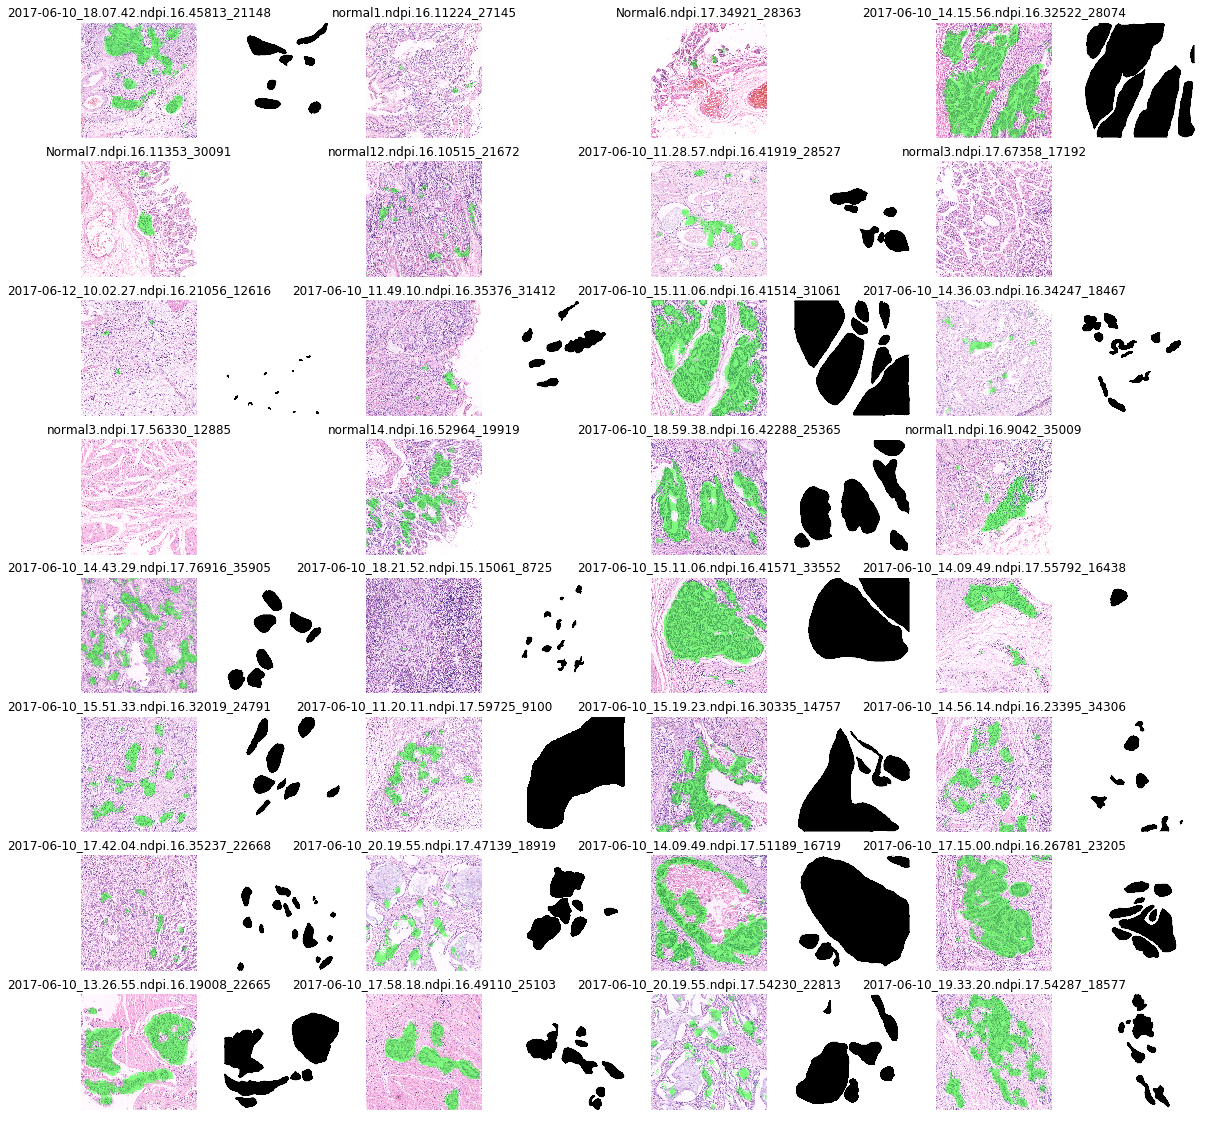

In [9]:
fig = plt.figure(figsize=(20,20))

for idx in range(32):
    ax1 = fig.add_subplot(8,8,2*idx+1)
    ax2 = fig.add_subplot(8,8,2*idx+2)
    img_predict = l_im[idx]
    try:
        img_groundtruth = scipy.misc.imread(l_label_file[idx])
    except:
        img_groundtruth = np.zeros_like(l_im[idx])+255

    ax1.imshow(img_predict)
    ax2.imshow(img_groundtruth[:,:,0], "Greys")
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.set_title(l_sample[split_idx:][idx].split(".2048")[0])
        

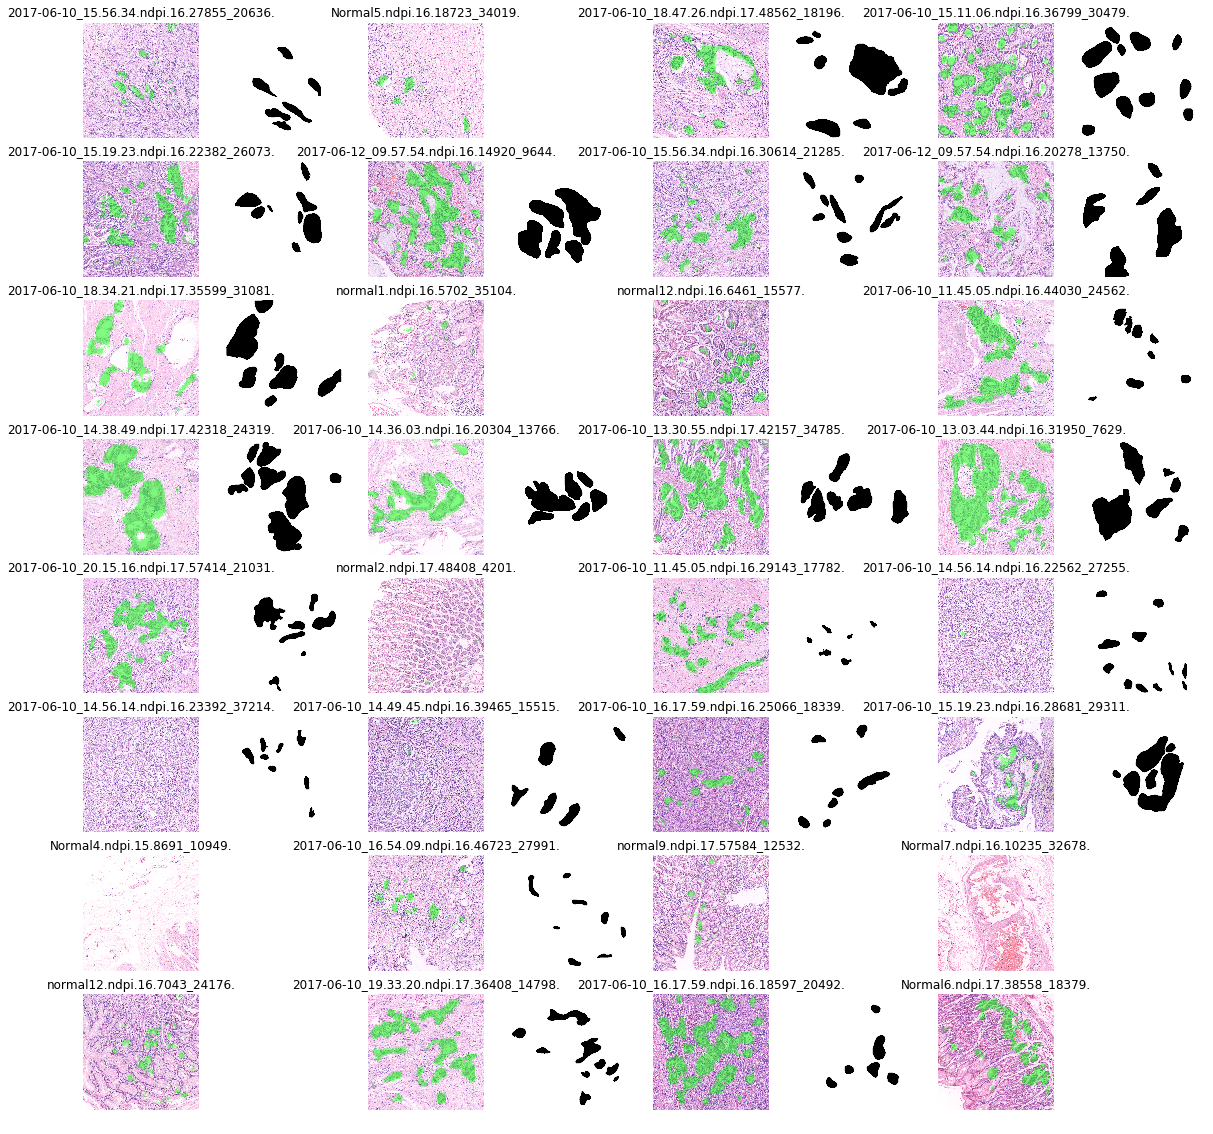

In [10]:
fig = plt.figure(figsize=(20,20))

for idx in range(32):
    ax1 = fig.add_subplot(8,8,2*idx+1)
    ax2 = fig.add_subplot(8,8,2*idx+2)
    idx += 32
    img_predict = l_im[idx]
    try:
        img_groundtruth = scipy.misc.imread(l_label_file[idx])
    except:
        img_groundtruth = np.zeros_like(l_im[idx])+255

    ax1.imshow(img_predict)
    ax2.imshow(img_groundtruth[:,:,0], "Greys")
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.set_title(l_sample[split_idx:][idx].split("2048")[0])
        